In [1]:
# general imports needed by functions
import errno    
import os

# import python scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import needed keras objects into current namespace
from keras import layers
from keras import models
from keras import optimizers


Using TensorFlow backend.


In [2]:
# set plotting visual style and parameters for all plotted figures
%matplotlib inline
sns.set_style('darkgrid') # use seaborn style to improve visual presentation
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12.0 , 8.0)

In [3]:
# check which devices tensorflow has recognized and is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4892741668285249494
]


# 6. Deep Learning for Text and Sequences

We will use *recurrent neural networks* and *1D convnets* for:

- Document classification and timeseries classification.
- Timeseries comparisons (estimate closeness sof documents or stockcs)
- Sequence-to-sequence learning (e.g. natural language translation)
- Sentiment analysis (postiive or negative movie reviews)
- Timeseries forecasting (predict future weather given timeseries of past weather).

## 6.1 Working with text data

Deep learning for NLP is pattern recognition applied to words, sentences and paragraphs, in much the same way
that computer vision is pattern recognition applied to pixels.

Like all machine learning and NN models, deep-learning need numeric tensors, they can't work with raw
text as input (as we have seen).  *Vectorizing* text is the process of transforming text into numeric tensors.
This can be done in multiple ways:
- Segment text into words, and transform each word into a vector.
- Segment text into characters, and transfrom each character into a vector.
- Extract n-grams of words or characters, and transform each n-gram into a vector.

Where *n-grams* are overlapping groups of multiple consecutive words or characters.

Generically, the different units we encode text into (words, characters, or n-grams) can be referred to
as *tokens*, and breaking text into such tokens is called *tokenization*.  The first step in parsing a
computer language in order to compile or interpret it is to tokenize the input, and likewise, the first step in
a NLP task is to tokenize the text before processing can begin.

All text-vectorization consists of applying some tokenization scheme then associating a resulting
numeric vector with the generated tokens.  These vectors, packed into sequence tensors, are fed
into deep neural networks.

Two major approaches to associating a numeric vector with tokens:
- *one-hot encoding*
- *token embedding* (typically for words known as *word embedding*.


This section looks at these two techniques in more detail (we have seen examples of one-hot encoding
in previous sections.  

### 6.1.1 One-hot encoding of words and characters

One-hot encoding is the most common and most basic way to turn character tokens into a vector.
It consists of associating a unique integer index with every word, and then turning this integer
index $i$ into a binary vector of size $N$ (the size of the vocabulary); the vector is all zeros
except for the $i$th entry, which is 1.

One-hot encoding can be done at the character level.

The toy example for word-level one-hot encoding (Listing 6.1)

In [4]:
# example samples.  In this example, each sample is a single sentence
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# build an index of all tokens in the data
token_index = {}
for sample in samples:
    # example of tokenizing by word.  In a real problem, we would (usually)
    # strip punctuation and special characters
    for word in sample.split():
        if word not in token_index:
            # an arbitrary unique index assigned for each word
            token_index[word] = len(token_index) + 1

# we only consider the first max_length words in each sample
max_length = 10

# where we store the results, tensor one entry for each sample
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

# vectorize the samples
for i, sample in enumerate(samples):
    # look at each word in the sample
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1 # one-hot encoding
        

# show the resulting representation
print(results.shape)
print(token_index)
print(results[0, 0, :]) # first word of first sample, The is index 1, one-hot encoded

(2, 10, 11)
{'The': 1, 'cat': 2, 'sat': 3, 'on': 4, 'the': 5, 'mat.': 6, 'dog': 7, 'ate': 8, 'my': 9, 'homework.': 10}
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


The toy example for character-level one-hot encoding

In [5]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
# all printable ASCII characters
characters = string.printable
# build index of the characters
# BUG: textbook reverses key/value of the token_index, we correct here
token_index = dict(zip(characters, range(1, len(characters) + 1)))


# vectorize the samples
max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
print(results[0, 0, :]) # first character of first sample
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        print(i, j, index, character)
        results[i, j, index] = 1
        
# show the resulting representation
print(results.shape)
print(token_index)
print(results[0, 0, :]) # first character of first sample

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0 0 56 T
0 1 18 h
0 2 15 e
0 3 95  
0 4 13 c
0 5 11 a
0 6 30 t
0 7 95  
0 8 29 s
0 9 11 a
0 10 30 t
0 11 95  
0 12 25 o
0 13 24 n
0 14 95  
0 15 30 t
0 16 18 h
0 17 15 e
0 18 95  
0 19 23 m
0 20 11 a
0 21 30 t
0 22 76 .
1 0 56 T
1 1 18 h
1 2 15 e
1 3 95  
1 4 14 d
1 5 25 o
1 6 17 g
1 7 95  
1 8 11 a
1 9 30 t
1 10 15 e
1 11 95  
1 12 23 m
1 13 35 y
1 14 95  
1 15 18 h
1 16 25 o
1 17 23 m
1 18 15 e
1 19 33 w
1 20 25 o
1 21 28 r
1 22 21 k
1 23 76 .
(2, 50, 101)
{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15,

Kerhas has built-in library functions for one-hot encoding of text at word or character level, starting from
raw text data.  They take care of stripping special characters and only using N most common words in the
dataset.

In [6]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# creates tokenizer configured to only use 1000 most common words
tokenizer = Tokenizer(num_words=1000)

# builds the word index
tokenizer.fit_on_texts(samples)

# turns strings into lists of integer indexes
sequences = tokenizer.texts_to_sequences(samples)

# other vectorizations are supported, but texts_to_matrix does same as we did above by hand
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# can be used to recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# show the results
print(word_index)
print(one_hot_results.shape)
print(one_hot_results[0,:])

Found 9 unique tokens.
{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}
(2, 1000)
[ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

A variant is *one-hot hasing*.  If number of unique tokens is very large, hash words into vectors of fixed size.
It is a hash, so *hash collisions* may occur and 2to different words end up with same hash.

In [7]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # hashes the word into a random integer index between 0 and 1000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1
        
print(results.shape)
print(results[0, 0, :])
print(abs(hash('The')) % dimensionality)

(2, 10, 1000)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0. 

### 6.1.2 Using word embeddings

Another populaer method is using dense *word vectors* also called *word embeddings*.

One-hot encodings are binary, sparse (mostly zeros) and very high-dimensional.

Word embeddings are low-dimensional floating-point vectors (that is dense vectors).
Word embeddings are learned from data.  It is common to see word embeddings that
are 256, 512 or 1024 dimensional when dealing with very large vocaularies.  

Two ways to obtain word embeddings:
- Learn word embeddings jointly with the main task (initially word vectors are random, and they are learned
  in the same way you learn weights).
- Load embeddings that were precomputed using a different machine-learning task.  These are
  *pretrained word embeddings*.
  
**Learning Word Embeddings with the Embedding Layer**

It is reasonable to *learn* a new embedding space with every new NLP task.  This can be done using
backpropagation, and Keras has special layers specifically for training a word embedding.  In this
case it becomes about learning the weights of this layer, the `Embedding` layer.

In [8]:
from keras.layers import Embedding

# 1000 is number of possible tokens, and 64 is the embedding dimensionality that
# willbe learned
embedding_layer = Embedding(1000, 64)

The `Embedding` layer that is learned is best understood as a dictionary that maps integer
indices (which stand for specific words) to dense vectors (64 dimensional real-valued number vectors
in this case).  It is effectively a dictionary lookup.  However, as discussed, the resulting embeddings,
once learned, have semantic meanings in the geometrical space that relate words to similar words.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`
where each entery is a sequence of integers.  It can embed sequences of variable lengths:
for instance, you could feed into the `Embedding` layer in the previous example batches with shapes
`(32, 10)` (batch of 32 wequences of length 10).  All sequences must have same length, so
will need to padd with zeros if too short or truncate if too long.

The `Embedding` layer returns a 3D floating-point tensor of shape
`(samples, sequence_length, embedding_dimensionality)`.
Such a 3D tensor can then be processed by an RNN layer or 1D convolution.

Iniitally the weights of such a layer are random.  During training, these vectors are adjusted,
structuring the space into something that can be exploited by the downstream task.  Once fully
trained, the embedding space will show a lot of structure.

Using the IMDB movie-review sentiment-prediction task.  We prepare the data.  We restrict to the top
10,000 most common words, and cut off the reviews after only 20 words.  This example will learn
an 8-dimensional embedding for each of the 10,000 words, turn the input integer sequence (2D integer
tensor) into the embedded sequence (3D float tensor), flatten the tensor to 2D, and train a single
`Dense` layer on top for classification (remember we are doing a binary classification of good vs. bad
review sentiment).


In [9]:
from keras.datasets import imdb
from keras import preprocessing

# number of words to considre as features
max_features = 10000
# cuts off text aftre this number of words
maxlen = 20

# loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(
     num_words=max_features)

# turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)
print(x_train[0,:])

(25000, 20)
(25000, 20)
[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32   15
   16 5345   19  178   32]


In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# specifies maximum input length, after the embedding layer, activation have shape (samples, maxlen, 8)
model.add(Embedding(max_features, 8, input_length=maxlen))

#flattens the 3D tensor of the embedding into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# add the classifier on top, use a sigmoid for a binary classifier
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 36us/step - loss: 0.6759 - acc: 0.6043 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 1s 32us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.4263 - acc: 0.8079 - val_loss: 0.5008 - val_acc: 0.7454
Epoch 5/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.3930 - acc: 0.8257 - val_loss: 0.4981 - val_acc: 0.7540
Epoch 6/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5013 - val_acc: 0.7534
Epoch 7/10
20000/20000 [==============================] - 1s 31us/step - loss: 0.3435 - acc: 0.8534 - val_loss: 0.5051 - val_acc:

You should get a validation accuracy of ~76%, which is pretty good considering we are only looking at first 20 words
of each review.

This architecutre leads to a model that treats each word in the input sequence separately (without considering
ordering or inter-word relationships).  It will be much better to add recurrent layers or 1D convolutions on top
of the embedding to learn features that take into account word sequences and orderings.

**Using Pretrained Word Embeddings**

Similar to using pre-trained convolutions for an image processing task, we can use embeddings used from
a previous large NLP task.

There are various precomputed databases of word embeddings that can be used in Keras. Word2vec is one
well known example.  Another is Global Vectors for Word Representation (GloVe).

This example shows using GlOve embeddings in a Keras model.

### 6.1.3 Putting it all together: from raw text to word embeddings

You'll use a similar model to before, embedding sentences in sequences of vectors, flattening them, and training
a `Dense` layer on top.  But here we used pretrained word embeddings, and instead of using pretokenized
IMDB data pacakged in Keras, you'll need to start from scratch by downloading the original data.

**Downloading the IMDB Data as Raw Text**

Download the raw IMDB dta from http://mng.bz/0tIo

Uncompress it.

In [13]:
import os

imdb_dir = '../data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

**Tokenizing the Data**

Let's vectorize the text and prepare a training and validation split.

Because pretrained word embeddings are meant to be particularly useful on problems where little
training data is available, we will use only first 200 samples for training.

## 6.2 Understanding recurrent neural networks

All networks so far have been strictly *feedforward networks*.  Feedforward networks have no memory.  Each input shown
is processed independently from others, with no state kept in between inputs.  In order to process sequences
with such a network, you have to present entire sequence all in 1 input.

A *recurrent neural network* (RNN) keeps a state: it processes sequences by iterating through sequence elements
and maintaining a *state* containing information relative to what it has seen so far.  It is a type of NN that has 
an internal loop.

To make notions of *loop* and *state* clear, we have a small toy example using `Numpy` only for the
implementation.  This RNN takes as input a sequence of vectors, which are encoded as a tensor
of size `(timesteps, input_features)`.  It loops over timesteps and, at each timestep,
it considers its current state at `t`.  We then set state for the next input to the previous output.  
For the first timestep, the previous output is not defined, so we initialize the state as all zeros
called *initial state*.

```python
# Pseudocode RNN

# The state at t
state_t = 0

# iterates over sequence of elements
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    # The prevous output becomes the state for the next iteration
    state_t = output_t
```

You can even flesh out the function `f`: the transformation of the input and state into
an output will be parameterized by two matrices, `W` and `U`, and a bias vector.  It is
similar to the transformation operation operated by a densely connected layer.

```python
# More detailed pseudocode for the RNN

# The state at t
state_t = 0

# iterates over sequence of elements
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    # The previous output becomes the state for the next iteration
    state_t = output_t
```

To make absolutely unambiguous, let's write a naive `Numpy` implementation of the forward
pass of the simple RNN.

In [14]:
# number of timesteps in the input sequence
timesteps = 100

# dimensionality of the input feature space
input_features = 32

# dimensionality of the output feature space
output_features = 64

# input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))

# initial state: an all-zero vector
state_t = np.zeros((output_features,))

# create random weight matrices, these would be trained by gradient descent
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

# holds the history of the outputs
successive_outputs = []

# input_t is a vector of shape (input_features,)
for input_t in inputs:
    # combines the input with the current state (the previous output) to obtain the current output
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    # stores this output in a list
    successive_outputs.append(output_t)
    
    # updates the state of the network for the next timestep
    state_t = output_t
    
# the final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0).reshape((timesteps, output_features))


print(final_output_sequence.shape)

(100, 64)


In [15]:
print(len(successive_outputs))
print(successive_outputs[0].shape)
print(successive_outputs[0])
print(final_output_sequence[0,:])
print(np.allclose(successive_outputs[0], final_output_sequence[0,:]))

100
(64,)
[ 0.99999999  0.99999994  0.99999998  0.99999324  0.99999989  0.99999998
  0.99999929  1.          0.99999981  0.99999996  0.99999999  0.99999991
  1.          0.99999998  0.99999988  0.99999977  0.99999998  0.99999994
  0.99999995  1.          0.99999959  0.99999999  0.99999617  0.99999993
  0.99999986  1.          0.99999998  0.99999994  0.99999819  1.
  0.99999985  0.99999999  0.99999885  1.          0.99999998  0.99999894
  1.          0.99999996  1.          1.          1.          1.
  0.99999971  0.9999967   0.9999962   0.99999996  0.99999999  0.99999998
  0.99999935  0.99999997  0.9999998   1.          0.9999994   0.99999999
  0.99999989  0.99994312  0.99999998  0.99999981  0.99999995  0.99999996
  0.99999995  1.          0.99999995  0.99999987]
[ 0.99999999  0.99999994  0.99999998  0.99999324  0.99999989  0.99999998
  0.99999929  1.          0.99999981  0.99999996  0.99999999  0.99999991
  1.          0.99999998  0.99999988  0.99999977  0.99999998  0.99999994
  0.999

RNN is a for loop that reuses quantities computed during previous iteration of loop.

RNNs are characterized by their step function, which in the previous code was

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

### 6.2.1 A recurrent layer in Keras

The `SimpleRNN` layer in Keras corresponds to the previous example.  One minor difference: `SimpleRNN`
processes batches of sequences (like all other Keras layers), not a single sequence as in the previous
example.  This means it takes inputs of shape `(batch_size, timesteps, input_features)`.

`SimpleRNN` can be run in 2 different modes: it can return either the full sequence of successive
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, input_features)`) or 
only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`).
These two modes are controlled by the `return_sequences` constructor argument.

If we don't specify, the default is to return only the last output

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

In [17]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence by specifying the `return_sequences` constructor
parameter:

In [18]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Notice the (slight) difference in the returned shape from the RNN layer in the second example.  

It is sometimes useful to stack several recurrent layers one after the other in order to increase the
representational power of a network.  In such a setup, you have to get all of the intermediate layers
to return full sequence of outputs:

In [19]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
# Last layer only returns the last output
model.add(SimpleRNN(32))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model on the IMDB movie-review-classification problem.  First we preprocess
the data.

In [20]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# number of words to consider as features
max_features = 10000
# cuts off text after this many words
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer.

In [21]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 672us/step - loss: 0.6507 - acc: 0.6046 - val_loss: 0.5571 - val_acc: 0.7246
Epoch 2/10
20000/20000 [==============================] - 13s 658us/step - loss: 0.4208 - acc: 0.8205 - val_loss: 0.4529 - val_acc: 0.7918
Epoch 3/10
20000/20000 [==============================] - 13s 662us/step - loss: 0.2988 - acc: 0.8804 - val_loss: 0.4168 - val_acc: 0.8216
Epoch 4/10
20000/20000 [==============================] - 13s 674us/step - loss: 0.2308 - acc: 0.9122 - val_loss: 0.4161 - val_acc: 0.8204
Epoch 5/10
20000/20000 [==============================] - 13s 654us/step - loss: 0.1594 - acc: 0.9420 - val_loss: 0.5027 - val_acc: 0.8286
Epoch 6/10
20000/20000 [==============================] - 13s 656us/step - loss: 0.0984 - acc: 0.9661 - val_loss: 0.4790 - val_acc: 0.8460
Epoch 7/10
20000/20000 [==============================] - 13s 654us/step - loss: 0.0637 - acc: 0.9801 - val_loss: 0.5

Now, lets display the training and validation loss and accuracy.

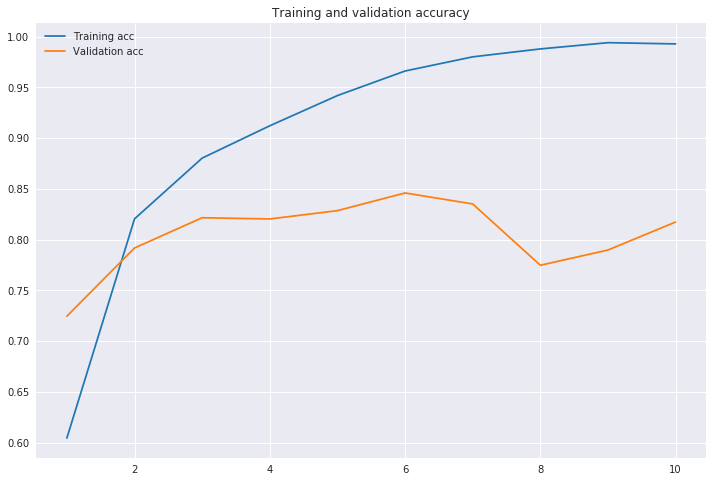

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

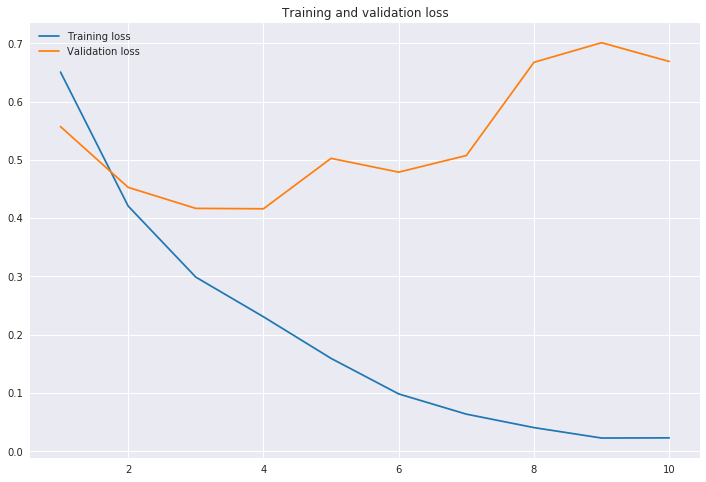

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

As a reminder, in chapter 3 we achieved 88% using a `Dense` network.  Unfortunately this small
recurrent network doesn't perform well combared to this.  The network is overfitting, so it could be improved.

Part of the problem is that we only consider the first 500 words of each review, rather than the
full sequences.  But the bigger problems is that `SimpleRNN` are simply not goot at processing too long
of a sequence, such as written text.  We need other types of recurrent layers which perform
much better on long sequences.

# 6.2.2 Understanding the LSTM and GRU layers

There are 2 other recurrent layers available in Keras: `LSTM` and `GRU`.  `SimpleRNN` is too simple so in
practice we need to use one of these other types of RNN.

`SimpleRNN` suffers from *vanishing gradient problem*.  This effect can also be a problem for deep neural
networks.  It comes about because the information passed back through the gradiants via backpropagation
becomes a weaker signal the further back  you have to transmit it.  In effect, the itteration of the
`SimpleRNN` through time means that the vanishing gradient problem is especially accute.  The
`LSTM` and `GRU` recurrent layers were designed to solve this problem.

Long Short-Term Memory (LSTM) is a variant of the `SimpleRNN`.  It adds a way to carry information
across many timesteps.  It saves (gradient) information for later, thus preventing older signals from
vanishing during processing (espeically for long time sequences).

LSTM is complex, though no more complicated than the `SimpleRNN`. Feedforward computation.  We still have a `U`,
`W` and `b` matrix to compute the output.  But we have an additional bit of
carry information.  The carry information is computed from 3 separate, but same type of matrix
multiplicaiton and addition functions.  This bit of carry information is also considered and added to
the output function. that is computed.

The carry signal is composed of 3 components, labeled `i`, `f` and `k`.  You can interpret these as
a way of forgetting `f` irrelevant information in the carray dataflow, while `i` and `k` provide
information about the present, updating the carry track with new information.  

But in short, just keep in mind what the `LSTM` cell is meant to do: allow past information to be
reinjected at a later time, thus fighting the vanishing-gradient problem.

# 6.2.3 A concrete LSTM example in Keras

Here we use a `LSTM` layer to see how it improves the recurrent network on the IMDB dataset.

In [25]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 32s 2ms/step - loss: 0.5052 - acc: 0.7643 - val_loss: 0.3376 - val_acc: 0.8576
Epoch 2/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2886 - acc: 0.8866 - val_loss: 0.3210 - val_acc: 0.8592
Epoch 3/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.2297 - acc: 0.9120 - val_loss: 0.3207 - val_acc: 0.8830
Epoch 4/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1956 - acc: 0.9271 - val_loss: 0.3074 - val_acc: 0.8664
Epoch 5/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1728 - acc: 0.9379 - val_loss: 0.3039 - val_acc: 0.8932
Epoch 6/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1549 - acc: 0.9425 - val_loss: 0.3521 - val_acc: 0.8848
Epoch 7/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1402 - acc: 0.9497 - val_loss: 0.3565 - val_acc:

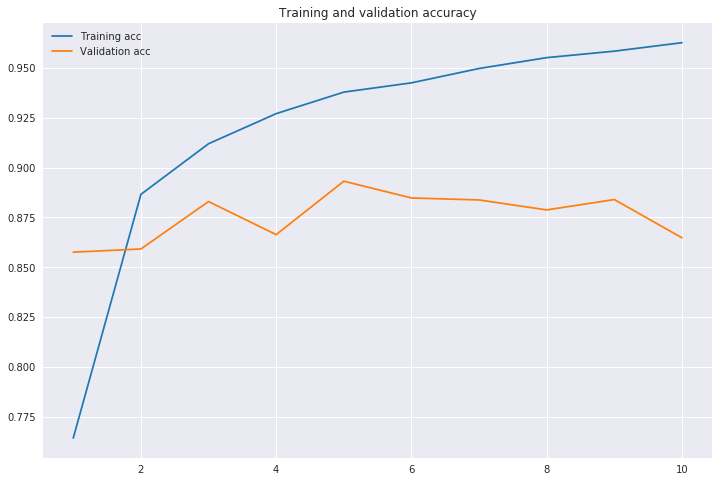

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

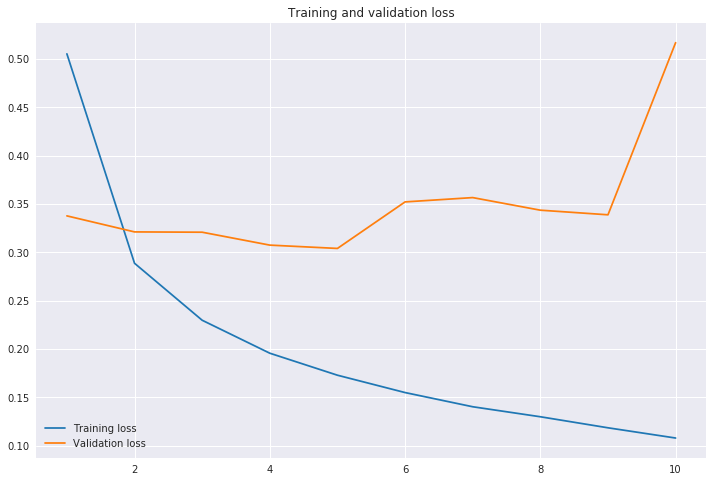

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

This time, we should achieve up to 89% validation accuracy.  This should be better than the `SimpleRNN`
performance, and a bit better than the simple feedforward model from chapter 3 as well.  And again
recall we are still only looking at first 500 words (500 timesteps in the recurrent formulation), whereas
in chapter 3 we were using the full text for all reviews.

But the result isn't significally better, especially considering the much greater computational machinery
now present in the `LSTM`.  Again we may be able to increase performance a bit by tuning the hyper-parameters.
But, as argued in textbook, we probably can't improve much over just simply looking at which words are used
and their frequency.  Thus the simpler model for this simple binary classification task may be difficult to improve
upon using more complex recurrent networks.  

But there are far more difficult natural-language processing problems where LSTM and GRU will make a much
greater difference.

# 6.2.4

- A RNN is a recurrent neural network, you can think of it as implementing a loop that processes a sequence of
  input, and feeds the state (output) from previous timestep into calculation of the next output state.
- LSTM adds in mechanisms to address the vanishing gradients problem, which is especially problematic for recurrent
  neural networks.
- Embedding layers are an alternative to simple one-hot or bag-of-word encodings, that are especially powerful
  for more complex NLP tasks.

# 6.3 Advanced use of recurrent neural networks

Here we look at 3 advanced techniques for RNN.

- *Recurrent dropout* A specific way to use dropout to fight overfitting in recurrent layers
- *Stacking recurrent layers* This increases the representational power of the network.
- *Bidirectional recurrent layers* These present the same information to a recurrent network
  in different ways, increasing accuracy and mitigating forgetting issues.

# 6.3.1 A temperature-forecasting problem

In this example, we use a time series sequence of weather data, rather than NLP data.  This is weather
data recorded from a weather station in Jena Germany.  

In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity,
wind direction, and so on) were recorded every 10 minutes, over several years.  

In these examples, we will build a model that will take several days worth of data points, and learn to
predict the air temperature 24 hours in the future.

We need to download from: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [30]:
import os

data_dir = '../data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


The dataset consists of over 420,000 data samples.

Now convert all of the lines of data into a `Numpy` array.

In [31]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Here is the plot of temperature (in degress Celsius) over time.  We can clearly see the yearly periodicity
of the temperature.

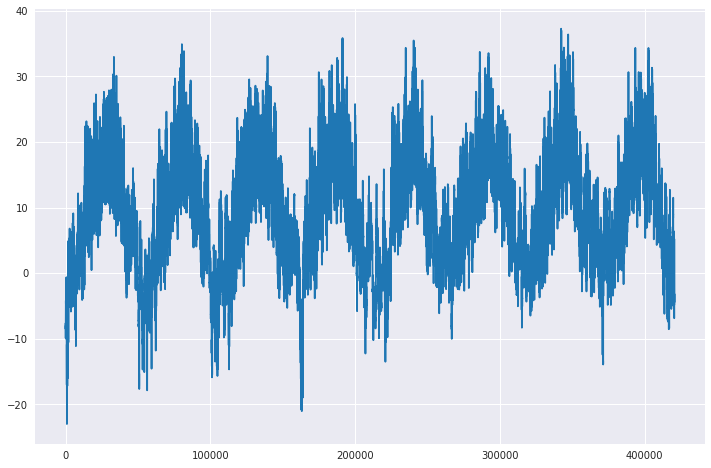

In [32]:
# all 7 years
temp = float_data[:, 1] # col 1 is temperature in degress Celsius
plt.plot(range(len(temp)), temp)

Here is first 10 days of data.  Because data is recorded every 10 minutes, we get 144 data points per day.

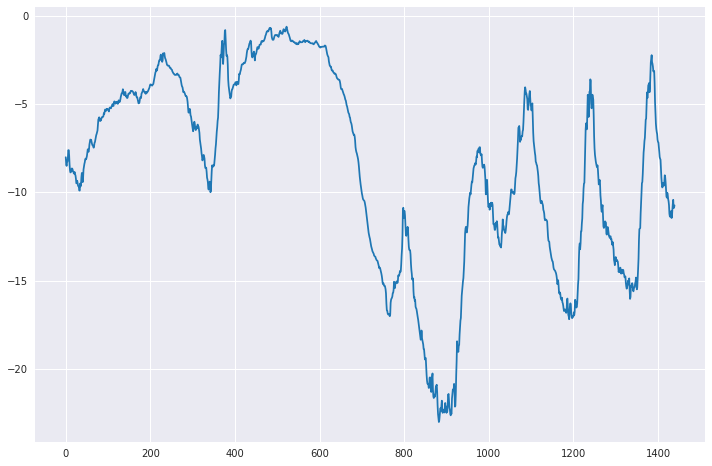

In [33]:
# first 10 days of data
plt.plot(range(1440), temp[:1440])

If we were trying to predict average termperature for the next month given a few past months, the problem would
be easy, due to the reliable year-scale periodicity of the data.  But looking at the data over a scale of days,
the temperature looks a lot more chaotic.  Is this timeseries predictable at a daily scale?  

# 6.3.2 Preparing the data


The exact formulation of the problem will be: given data going as far back as `lookback` timesteps (a timestep is 10
minutes) and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps?

We will use:

- `lookback` = 720 - Observations will go back 5 days
- `steps` = 6 - Observations will be sampled at one data point per hour
- `delay` = 144 - Targets will be 24 hours in the future


To get started, we need to perform 2 things:

- Preprocess the data to a format a (recurrent) neural network can ingest.
  - Data is already numerical.
  - But each timeseries is on a different scale (temperature ranges from -20 to +30 but pressure is around 1000)
  - So we need to normalize each timeseries independently so that they all take small values on a similar scale.
- Write a generator that takes the current array of float data and yields batches of data from the recent past,
  along with a target temperature in the future.
  - Because samples are highly redundant, we will generate samples on the fly using the original data.
  
We will normalize the data using the straightforward method of subtracting the mean and dividing by the 
standard deviation for each feature.  We will use only the first 200,000 timesteps for the training data,
so we need to compute the mean and sd only on this data (so we don't leak meta-parameter info into our
validation/test results).

In [34]:
num_train = 200000

# subtract means for each feature (axis=0) from all data
mean = float_data[:num_train].mean(axis=0)
float_data -= mean

# likewise, divide by standard deviation of each feature
std = float_data[:num_train].std(axis=0)
float_data /= std

Here we will create the data generator.  It yields a tuple `(samples, targets)`, where `samples` is one
batch of input data and `targets` is the corresponding array of target temperatures.  It takes the
following arguments:

- data - The original array of floating-pont data (after being normalized)
- lookback - How many timesteps back the input data should go
- delay - How many timesteps in the future the target should be
- min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
  This is useful for keeping a segment of the data for validation and another for testing.
- shuffle - Whether to shuffle the samples or draw them in chronological order.
- batch_size - The number of samples per batch.
- step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
  one data point every hour.

In [35]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''Generator for a "data" timeseries.
    
    Parameters
    ----------
    data - The original array of floating-pont data (after being normalized)
    lookback - How many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
      This is useful for keeping a segment of the data for validation and another for testing.
    shuffle - Whether to shuffle the samples or draw them in chronological order.
    batch_size - The number of samples per batch.
    step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
      one data point every hour.    
  
    Returns
    -------
    Returns a numpy array of the input samples shape (batch_size, lookback//step, num_features) and another numpy array of
    the targets of shape (batch_size,)
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                     min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty numpy array to gather and return the resulting samples we select
        samples = np.zeros((len(rows), 
                           lookback // step,
                           data.shape[-1]))
        
        # likewise, empty array to hold the resulting targets to be returned
        targets = np.zeros((len(rows),))
        
        # rows have been slected (either random or the next batch), extract the input samples and output targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(indices)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

We can use this function to instantiate 3 generators, one for training, validation and testing.  Each will
look at different temporal segments of the original data.  Training looks at first 200,000 timesteps.  Validation
looks at next 100,000 and test looks at remainder.

In [36]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen =   generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_gen =  generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

# how many steps to draw from val_gen in order to see 
# the entire validation set
# NOTE: looks like bug in book, if you don't divide by batch_size, you will draw WAY too many samples
# to complete a validation
val_steps = (300000 - 200001 - lookback) // batch_size

# how many steps to draw from test_gen in order to see
# the entire test set
# NOTE: ditto, need to divide by batch_size or else draw many more items from test than needed
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 6.3.3 A common-sense, non-machine-learning baseline

We have talked about a baseline model before.  Before using a complex black-box deep-learning model to solve
the temperature prediciton problem, what is a reasonable performance we could expect to achieve using some simple
common-sense approach.  This will serve as a sanity check, and it will establish a baseline performance that our
more complex model should beat if we consider it to be working at all.

A common-sense first approximation is to always predict that the temperature in 24 hours will be equal to the
current temperature.  Let's evaluate this "prediction" model, using the mean absolute error (MAE) metric:

```python
np.mean(np.abs(preds - targets))
```

Here is how we can calculate the MAE for our validation data, where we always predict that the temperature
will be equal to the last sample temperature.

In [37]:
print(val_steps)

769


In [38]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # our naive method is to predict temp is equal to the last temperature in input
        if step % 1000 == 0:
            print(step)
            print(samples.shape)
            print(preds.shape)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mae = evaluate_naive_method()
print(mae)

0
(128, 240, 14)
(128,)
0.289735972991


This yields a MAE of 0.29.  Recall that the data we are working with was normalized, so the temperature (like all
other features) has a mean of 0 and a sd of 1.  We can translate it (unnormalize it) by multiplying by the
standard deviation that we divided the data by

In [39]:
celsius_mae = mae * std[1]
print(celsius_mae)

2.56488743498


This indicates that the MAE is over 2.5 degrees C, which is not bad, but not great.  Now the game is to use
deep learning and RNN to do better.

# 6.3.4 A basic machine-learning approach

In the same way it's useful to establish a common-sense baseline, it also useful to first try a cheap (shallow)
machine-learning model (such as a small, densly connected network). 

We first create a small fully connected model that starts by flatening the data and running it through 2 `Dense`
layers.  Note that this is a regression problem, so we don't use any activation function on the last layer.
We use MAE as the loss.  Because we use the exact same metric as the naive common-sense approach, we can directly
compare this model with the naive prediction.

In [40]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [41]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [42]:
model.compile(optimizer=RMSprop(lr=0.0001), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 0.4479 - val_loss: 0.3839
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3611 - val_loss: 0.3683
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3319 - val_loss: 0.3790
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3114 - val_loss: 0.3952
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2962 - val_loss: 0.3803
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2828 - val_loss: 0.3649
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2741 - val_loss: 0.3500
Epoch 8/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2655 - val_loss: 0.3436
Epoch 9/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2570 - val_loss: 0.3474
Epoch 10/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2495 - val_lo

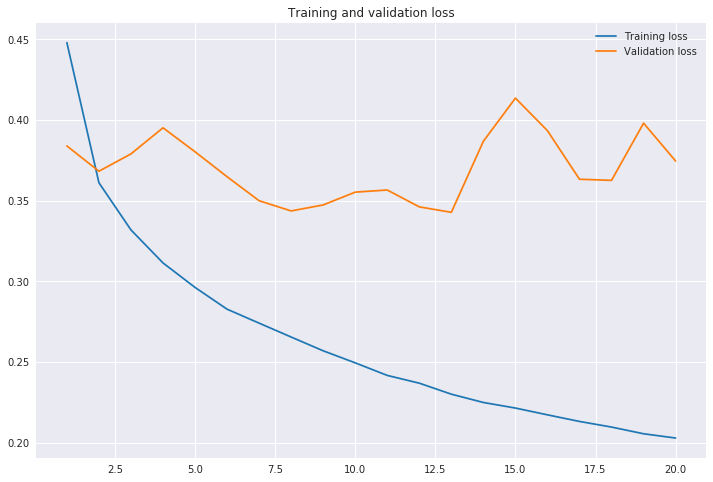

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

NOTE: Was diverging for me.  Had to reduce lr by 1 order of magnitude in order to get similar results to those
shown in textbook.

Since we are using MAE for the loss, we can directly compare the training and validation loss (MAE) here to
our naive results.  Some of the validation MAE/loss get closs to the 0.29 naive result (though not quite
there for me when I tried it).  Good discussion in textbook here.  If there is a simple naieve solution, why doesn't
the model find it?  The same could be asked for the Titanic dataset results most of the students saw.  The simple
solution is within the space of models defined by this fully connected model.  

This is a pretty significant limitation of ML in general:

**Conclusion**: unless the learning altorighm is hardcoded to look for a specific model, parameter learning can
sometimes fail to find a simple solution to a simple problem.


# 6.3.5 A first recurrent baseline

The first fully connected NN did not achieve the naive baseline performance.  The previous example flattned the
timeseries, which removed the notion of time from the input data.

Let's use RNN approach so we can preserve this sequence information, where causality and order matter.

We introduce the GRU layer (Gated Recurrent Unit).  It uses same principle as LSTM but somewhat more streamlined.
The streamlining may mean GRU doesn't have quite as much representational power as an LSTM.  But there is always
a tradeoff between representational power and computational effort in machine learning models.

In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [45]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 0.3011 - val_loss: 0.2680
Epoch 2/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2850 - val_loss: 0.2756
Epoch 3/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2800 - val_loss: 0.2642
Epoch 4/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2735 - val_loss: 0.2689
Epoch 5/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2679 - val_loss: 0.2605
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2638 - val_loss: 0.2595
Epoch 7/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2595 - val_loss: 0.2613
Epoch 8/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2534 - val_loss: 0.2631
Epoch 9/20
500/500 [==============================] - 55s 111ms/step - loss: 0.2487 - val_loss: 0.2633
Epoch 10/20
500/500 [==============================] - 55s 111ms/step - l

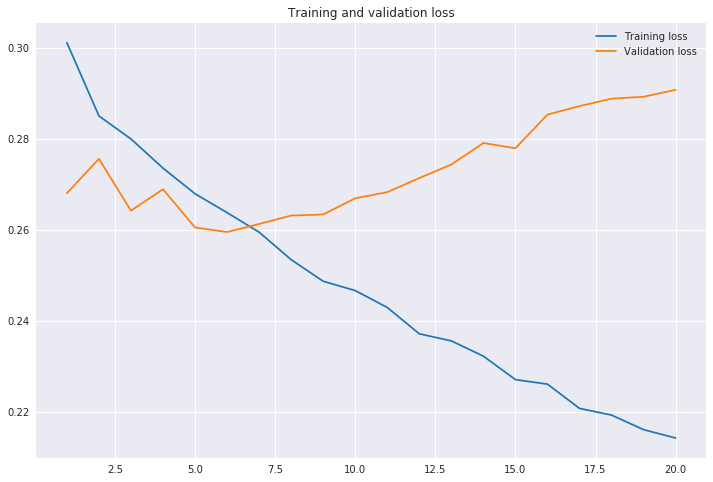

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

This should show better results.  We can significantly beat the common-sense baseline with this recurrent
model.  We achieve a MAE/loss of around 0.265.  The model immediately begins to overfit as well, indicating we
can regularize it and maybe push it even further.  This MAE translates to an error of 2.35 degrees Celcius after
denormalizing it.  This is a solid gain from before.

### 6.3.6 Using recurrent dropout to fight overfitting

It is evident from the MAE/loss that we overfit almost immediately.  Thus we should try and use some regularization
to fight this and improve our prediction ability.  

It is not an easy question of how to apply dropout regularization to a recurrent network.  Recent results have
shown that it can be done.  In short, we need to use the same dropout mask for all time steps of the recurrent
calculation.

Because of this need for the dropout mask to be preserved in time, we can't use a separate dropout layer, as we
conceputally can with straightforward feedforward networks.  Thus recurrent layers need to support
dropout regularization directly (in current Keras conceptualizations of layers).

Every recurrent layer in Keras has 2 dropout related arguments.  `dropout`, a float specifying the dropout
rate for input units of the layer, and `recurrent_dropout` specifying the dropout rate of the recurrent units.
Let's add droput and recurrent dropout to the GRU layer and see how it impacts the overfitting we observed. 

Because dropout can slow down the rate of convergence, we need to train the models longer now.

In [47]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [48]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [49]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 62s 124ms/step - loss: 0.3347 - val_loss: 0.2777
Epoch 2/40
500/500 [==============================] - 62s 123ms/step - loss: 0.3163 - val_loss: 0.2756
Epoch 3/40
500/500 [==============================] - 62s 123ms/step - loss: 0.3089 - val_loss: 0.2736
Epoch 4/40
500/500 [==============================] - 62s 124ms/step - loss: 0.3033 - val_loss: 0.2661
Epoch 5/40
500/500 [==============================] - 62s 124ms/step - loss: 0.3003 - val_loss: 0.2698
Epoch 6/40
500/500 [==============================] - 62s 124ms/step - loss: 0.2972 - val_loss: 0.2712
Epoch 7/40
500/500 [==============================] - 62s 124ms/step - loss: 0.2939 - val_loss: 0.2720
Epoch 8/40
500/500 [==============================] - 62s 124ms/step - loss: 0.2936 - val_loss: 0.2731
Epoch 9/40
500/500 [==============================] - 62s 124ms/step - loss: 0.2935 - val_loss: 0.2690
Epoch 10/40
500/500 [==============================] - 62s 124ms/step - l

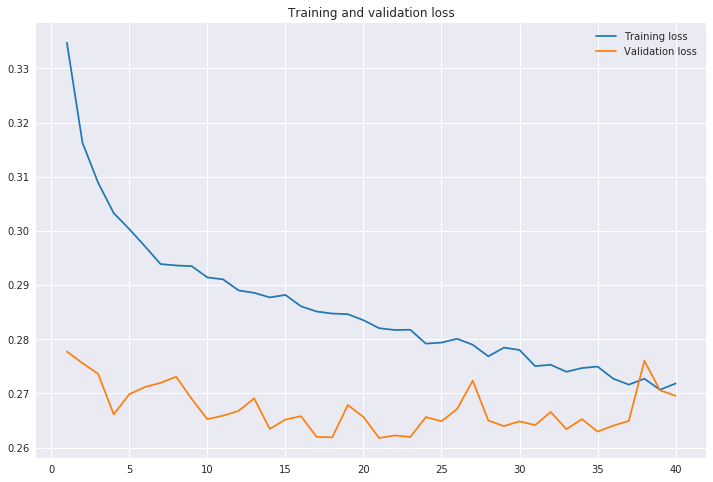

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Once again plotting the MAE/loss shows the results.  Success! We are no longer overfitting.  The loss/mae appears
to continue to be reduced over 40 generations, and achieves a best MAE of 0.26.

Although we seem to have stopped overfitting, our best validation scores haven't improved too much yet.

### 6.3.7 Stacking recurrent layers

Because we are no longer overfitting but seem to have hit a performance bottleneck, we should consider
increasing the capacity of the network.  

It is generally a good idea to increase the capacity of your network until overfitting becomes the
primary obstacle.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full
sequence of outputs (a 3D tensor).



In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [52]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [53]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 184s 367ms/step - loss: 0.3355 - val_loss: 0.2814
Epoch 2/40
500/500 [==============================] - 183s 365ms/step - loss: 0.3127 - val_loss: 0.2749
Epoch 3/40
500/500 [==============================] - 183s 366ms/step - loss: 0.3085 - val_loss: 0.2714
Epoch 4/40
500/500 [==============================] - 183s 366ms/step - loss: 0.3035 - val_loss: 0.2792
Epoch 5/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2998 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2952 - val_loss: 0.2637
Epoch 7/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2930 - val_loss: 0.2663
Epoch 8/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2885 - val_loss: 0.2665
Epoch 9/40
500/500 [==============================] - 183s 366ms/step - loss: 0.2874 - val_loss: 0.2634
Epoch 10/40
500/500 [==============================] - 183s 366m

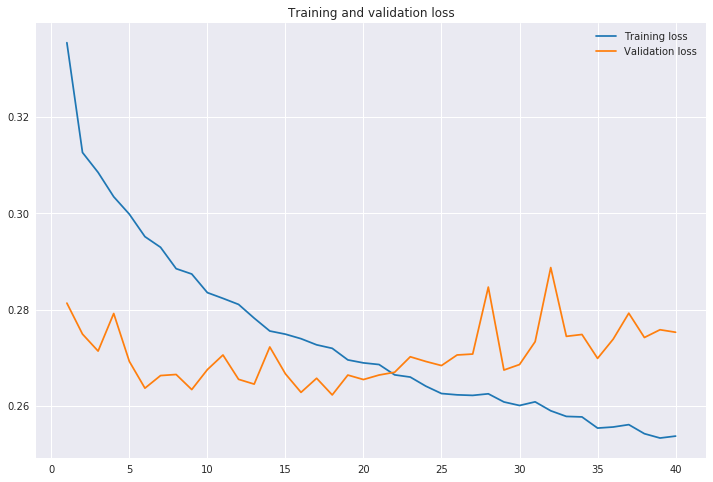

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# 6.3.8 Using Bidirectional RNNs

By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a
unidirectional RNN.

For some types of tasks (like many natural languages), it turns out that the forward chronological order is
a bit arbitrary.  Or another way to put it, there are also patterns that can be learned if you go backward in
time, from the last words spoken to the first.  

We can easily create a generate in Python that yields the word orders in reverse order, and thus see if we train
with the sentences reversed how well the system can learn.  (We use -1 step size to reverse the sample
sequences).

Training the same one-GRU-layer network we used in 6.3.5, using a generator, yields the following results:

In [55]:
def generator_rev(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''Generator for a "data" timeseries.  Yields a generator that returns the chronolgical sequences
    in reverse order.
    
    Parameters
    ----------
    data - The original array of floating-pont data (after being normalized)
    lookback - How many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
      This is useful for keeping a segment of the data for validation and another for testing.
    shuffle - Whether to shuffle the samples or draw them in chronological order.
    batch_size - The number of samples per batch.
    step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
      one data point every hour.    
  
    Returns
    -------
    Returns a numpy array of the input samples shape (batch_size, lookback//step, num_features) and another numpy array of
    the targets of shape (batch_size,)
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                     min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty numpy array to gather and return the resulting samples we select
        samples = np.zeros((len(rows), 
                           lookback // step,
                           data.shape[-1]))
        
        # likewise, empty array to hold the resulting targets to be returned
        targets = np.zeros((len(rows),))
        
        # rows have been slected (either random or the next batch), extract the input samples and output targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(indices)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples[:, ::-1, :], targets

In [56]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_rev_gen = generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_rev_gen =   generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_rev_gen =  generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

# how many steps to draw from val_gen in order to see 
# the entire validation set
# NOTE: looks like bug in book, if you don't divide by batch_size, you will draw WAY too many samples
# to complete a validation
val_steps = (300000 - 200001 - lookback) // batch_size

# how many steps to draw from test_gen in order to see
# the entire test set
# NOTE: ditto, need to divide by batch_size or else draw many more items from test than needed
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [57]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


In [58]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 56s 112ms/step - loss: 0.3005 - val_loss: 0.2720
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.2822 - val_loss: 0.2647
Epoch 3/20
500/500 [==============================] - 57s 113ms/step - loss: 0.2769 - val_loss: 0.2770
Epoch 4/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2730 - val_loss: 0.2707
Epoch 5/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2672 - val_loss: 0.2668
Epoch 6/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2617 - val_loss: 0.2648
Epoch 7/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2571 - val_loss: 0.2669
Epoch 8/20
500/500 [==============================] - 56s 111ms/step - loss: 0.2539 - val_loss: 0.2749
Epoch 9/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2519 - val_loss: 0.2716
Epoch 10/20
500/500 [==============================] - 56s 112ms/step - l

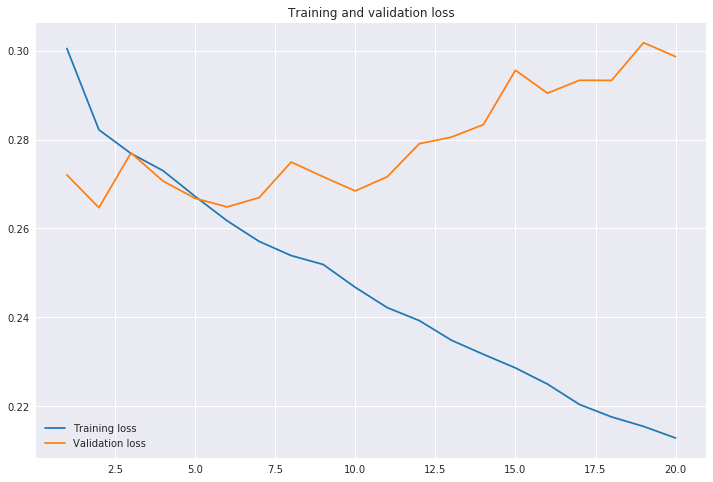

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In this case, the reversed-order GRU strongly underperforms even the common-sense baseline,
indicating that in this case, chronological process is important to the success of the approach.

But in this case, we are using the whether data, which is strongly chronological, so we shouldn't
be surprised that looking at data in reverse makes it harder to predict the trends.

But lets try the same idea on the LSTM IMDB example from section 6.2.  Here we are again training
the same LSTM, just using data where the review word order has been reversed.

In [61]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

In [63]:
# maximum number of words to consider as features
max_features = 10000

# Cuts texts off after this number of words
maxlen = 500

# load the data and reverse the sequences
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

# reverse the sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# pad the sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [64]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [66]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.4892 - acc: 0.7668 - val_loss: 0.3387 - val_acc: 0.8676
Epoch 2/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.3125 - acc: 0.8790 - val_loss: 0.3428 - val_acc: 0.8588
Epoch 3/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2585 - acc: 0.9026 - val_loss: 0.3148 - val_acc: 0.8672
Epoch 4/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2218 - acc: 0.9214 - val_loss: 0.3528 - val_acc: 0.8836
Epoch 5/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1884 - acc: 0.9347 - val_loss: 0.3700 - val_acc: 0.8754
Epoch 6/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1850 - acc: 0.9379 - val_loss: 0.3456 - val_acc: 0.8752
Epoch 7/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.1587 - acc: 0.9449 - val_loss: 0.6641 - val_acc:

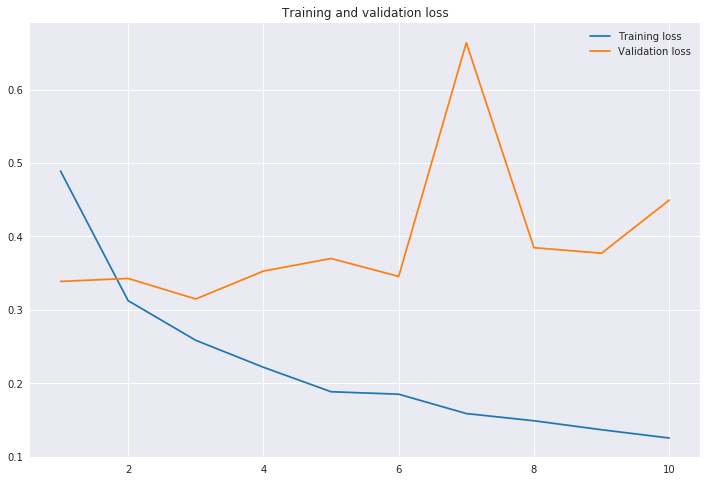

In [67]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In this case you should observe that you get performance nearly identical to that of the chronolgicaly correct
ordered LSTM we trained before on the same data.

Remarkably, reversed-order processing works just as well as regular chronological order on the natural
language reviews.  This confirms idea that, although word order *does* matter in understanding
language, *which* order you use isn't crucial.  Importantly RNN trained on reversed sequences will
learn different representations.

In ML representations that are *different* yet *useful* are always worth exploiting.  The more they differ, the better, they offer new insights into the problem being modeled.  This is the intuition behind *ensembling*
that is looked at in chapter 7.

A bidirectional RNN exploits this idea to improve on the performance on some kinds of tasks.  

In Keras we use the `Bidirectional` layer.

In [68]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [69]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.5573 - acc: 0.7190 - val_loss: 0.3779 - val_acc: 0.8550
Epoch 2/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.3373 - acc: 0.8713 - val_loss: 0.3863 - val_acc: 0.8642
Epoch 3/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2714 - acc: 0.9008 - val_loss: 0.5948 - val_acc: 0.8334
Epoch 4/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2317 - acc: 0.9171 - val_loss: 0.2996 - val_acc: 0.8820
Epoch 5/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.2076 - acc: 0.9266 - val_loss: 0.3241 - val_acc: 0.8866
Epoch 6/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1869 - acc: 0.9357 - val_loss: 0.4384 - val_acc: 0.8566
Epoch 7/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1692 - acc: 0.9415 - val_loss: 0.3586 - val_acc:

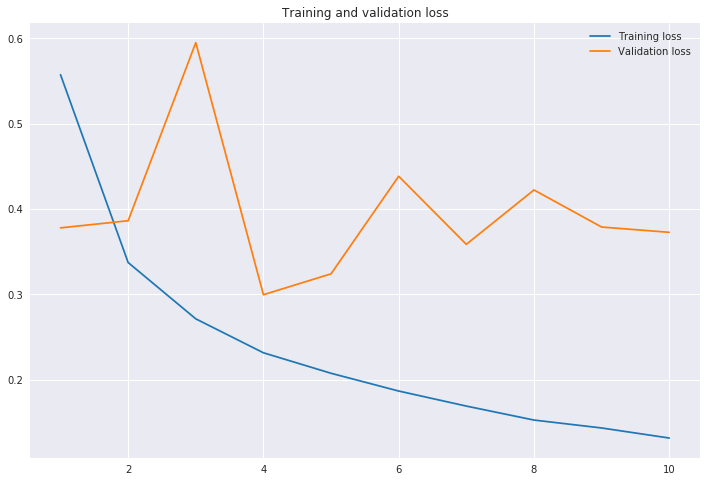

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

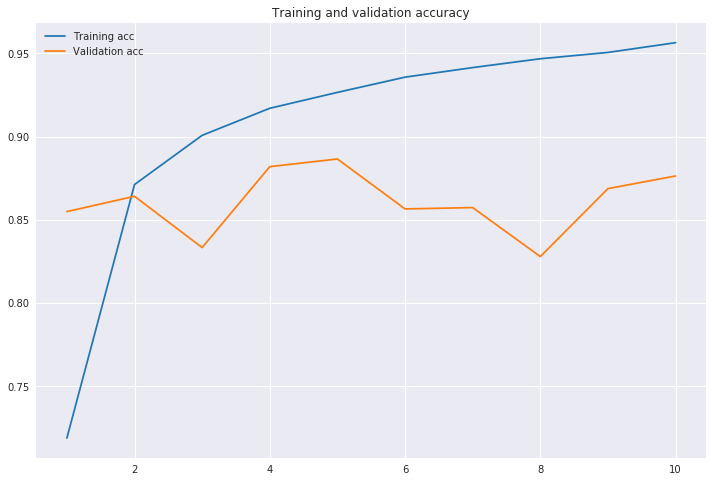

In [71]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

It performs slightly better than the regular `LSTM` you tried previously, achieving 89% validation accuracy.
It seems to overfit more quickly.  With some regularization, the bidirectional approach would
likely be a strong performre on this task.

Now let's try the same approach on the temperature-prediction data task.

In [72]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [73]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


In [75]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 72s 143ms/step - loss: 0.2930 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 70s 140ms/step - loss: 0.2743 - val_loss: 0.2718
Epoch 3/40
500/500 [==============================] - 70s 140ms/step - loss: 0.2665 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 70s 140ms/step - loss: 0.2629 - val_loss: 0.2708
Epoch 5/40
500/500 [==============================] - 70s 139ms/step - loss: 0.2556 - val_loss: 0.2722
Epoch 6/40
500/500 [==============================] - 70s 141ms/step - loss: 0.2490 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 71s 141ms/step - loss: 0.2448 - val_loss: 0.2822
Epoch 8/40
500/500 [==============================] - 70s 140ms/step - loss: 0.2393 - val_loss: 0.2797
Epoch 9/40
500/500 [==============================] - 70s 140ms/step - loss: 0.2327 - val_loss: 0.2802
Epoch 10/40
500/500 [==============================] - 70s 141ms/step - l

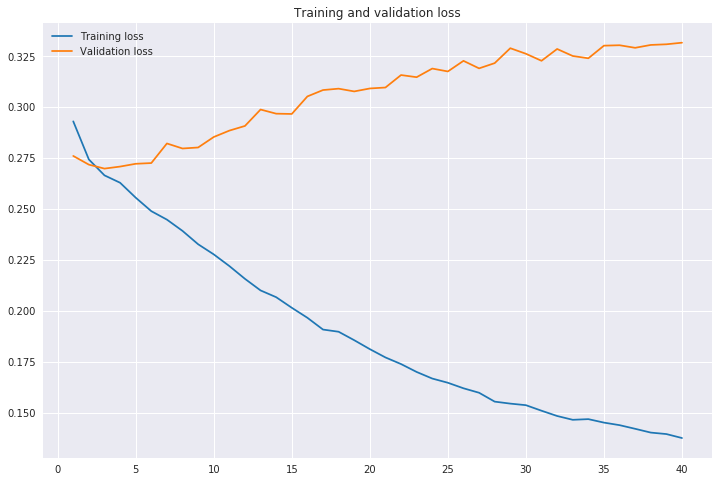

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The performs about as well as the regular GRU layer.  We don't get much, if any, benefit from the bidirectional
presentation, which should not be surprising.

### 6.3.9 Going even further

There are many other things you could try in order to improve performance on the temperature-forcasting problem:

- Adjust number of units in each recurrent layer (may be more optimal layer sizes)
- Adjust the learning rate
- Try using LSTM instead of GRU layers
- Try using a bigger densly connected regressor on top of the recurrent layers.  Maybe even a small stack of `Dense`
  layers.
- Don't forget to run your best meta-parameters eventually on the test set!

### 6.3.10 Wrapping
- First establish common-sense baselines of model/system you are tackeling.
- Try simple models before expensive ones.
- When temporal ordering matters, recurrent networks are the way to go.
- To use dropout with recurrent networks, in Keras use time-constant dropout mask and/or recurrent dropout mask.
- Stacked RNNs provide more power, but are more expensive.
- Bidirectional RNNs look at sequences in both directions.
  - They are useful on NLP problems.
  - But aren't strong on sequences where recent past is much more informative than the beginning of the sequence.

## 6.4 Sequence processing with convnets

Time can be treated as a spacial dimension, like
width or height.  

1D convnets can be competitive with RNNs on certain
sequence-processing problems, and usually at a 
consideradbly cheaper computational cost.

### 6.4.1 Understanding 1D convolution for sequence data

In the same way we convolve over 2D image data,
we can convolve over a sequence by treating it
as a 1D array, and colvolving patches or windows
along the sequence.  Each patch is then processed
as a subsequence.

1D convolution layers can recognize local patterns
in a sequence.  

### 6.4.2 1D pooling for sequence data

Keras has a 1D convnet layer.  It also has a 1D
pooling layer, which can be used in equivalent
way as 2D case to downsample and reduce the length
of 1D inputs (*subsampling*).  This is particularly useful for very long sequence data, to create a preprocessing step find small subsequences, that can
then later be analyzed by a full-blown recurrent layer.

### 6.4.3 Implementing a 1D convnet

In Keras, we use `Conv1D` layer for 1D convolutional
networks.  It takes as input 3D tensors with shape
`(samples, time, features)` and returns
similarly shaped 3D tensors.  The convolution window
is a 1D window on the temporal axis: axis 1 in the
input tensor.

Let's build a simple two-layer 1D convnet and
apply it to the IMDB sentiment classification task.


In [79]:
# obtain the imdb train/test data once again
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are typically structured same way
as we did with 2D counterparts, with alternating
layers of `Conv1D` and `MaxPooling1D`, ending
in either a global pooling layer or a `Flatten`
layer that turn the 3D outputs into 2D outputs.
We then usually use 1 or more `Dense` fully
connected layers to create a classifier
or regression on the extracted information.

One difference, we can use larger convolution windows
with 1D convnets.

Here is a 1D convnet model for the IMDB dataset.

In [80]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [81]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.8337 - acc: 0.5097 - val_loss: 0.6874 - val_acc: 0.5638
Epoch 2/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.6699 - acc: 0.6389 - val_loss: 0.6641 - val_acc: 0.6592
Epoch 3/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.6234 - acc: 0.7540 - val_loss: 0.6080 - val_acc: 0.7442
Epoch 4/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.5256 - acc: 0.8082 - val_loss: 0.4831 - val_acc: 0.8062
Epoch 5/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.4088 - acc: 0.8484 - val_loss: 0.4231 - val_acc: 0.8318
Epoch 6/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.3518 - acc: 0.8669 - val_loss: 0.4158 - val_acc: 0.8366
Epoch 7/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.3117 - acc: 0.8679 - val_loss: 0.4452 - val_acc:

Below are the training and validation loss and
accuracy results.  You should find that accuracy
is a bit less than the LSTM from previously, but
runtime/training time is faster.


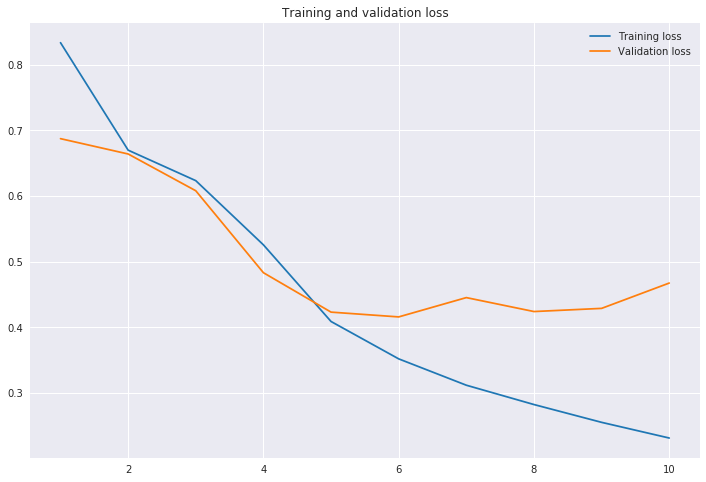

In [83]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

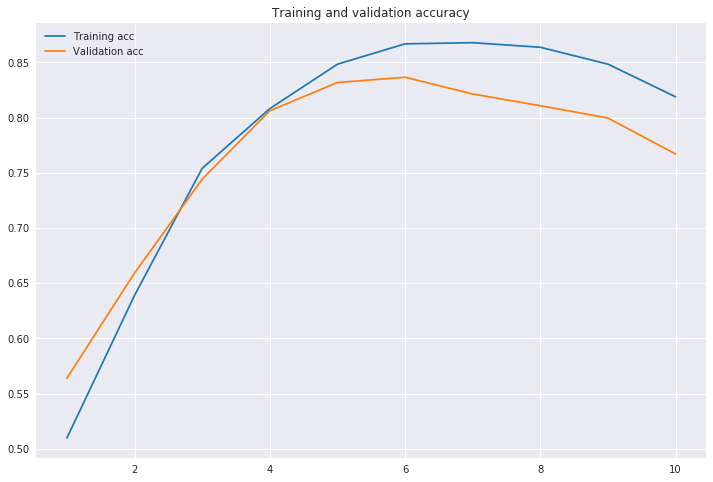

In [84]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### 6.4.4 Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches
independently, they are not sensitive to the
order of the timesteps, unlike RNNs.  To process
longer range sequences, you could stack on 1D
convnets and pooling layers.  But this is still
fairly week way to induce order sensitivity.

For example, if we try a stack of 1D convnets
on the temperature-forecasting problem, where
order-sensitivity is key to producing good predictions, you will find that performance is
very bad.

In [85]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [87]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [89]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 22s 44ms/step - loss: 0.4137 - val_loss: 0.4309
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3602 - val_loss: 0.4415
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3379 - val_loss: 0.4524
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3224 - val_loss: 0.4451
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3076 - val_loss: 0.4463
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3006 - val_loss: 0.4439
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2909 - val_loss: 0.4672
Epoch 8/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2850 - val_loss: 0.4375
Epoch 9/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2776 - val_loss: 0.4540
Epoch 10/20
500/500 [==============================] - 21s 43ms/step - loss: 0.271

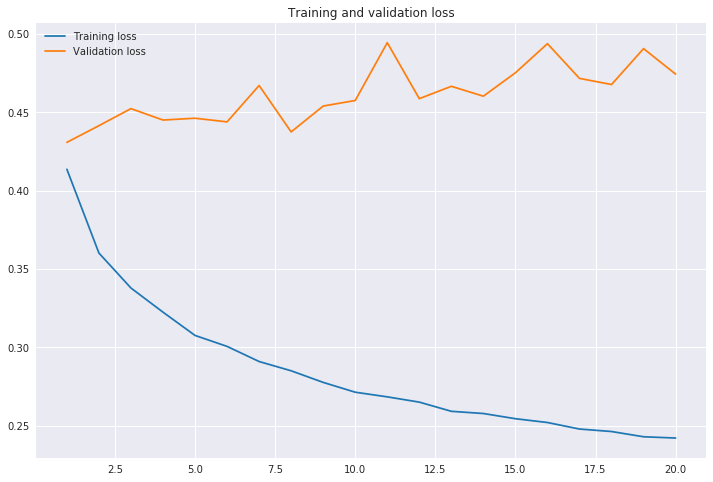

In [90]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The validation MAE stays in the 0.40s: we can't even
beat the common-sense baseline using the small 1D
convnet.

But one strategy is to combine the speed and 
lightness of convnets with the order-sensitivity
of RNN's, using the 1D convnet as a preprocessing
step before an RNN.  This is especially beneficial
if dealing with very long sequences that can't be 
realistically processed with RNNs.  The convnet
will turn the long input sequence into much shorter
(downsampled) sequences of higher-level features.

In [91]:
# previously set to 6, now 3 (1 point per 30 min)
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step)


We use a model starting with two Conv1D layers
for preprocessing, followed by a GRU layer.

In [92]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [93]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 41s 82ms/step - loss: 0.3388 - val_loss: 0.3010
Epoch 2/20
500/500 [==============================] - 41s 81ms/step - loss: 0.3035 - val_loss: 0.2800
Epoch 3/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2921 - val_loss: 0.2741
Epoch 4/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2855 - val_loss: 0.2812
Epoch 5/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2796 - val_loss: 0.2796
Epoch 6/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2736 - val_loss: 0.2747
Epoch 7/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2696 - val_loss: 0.2748
Epoch 8/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2637 - val_loss: 0.2743
Epoch 9/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2587 - val_loss: 0.2747
Epoch 10/20
500/500 [==============================] - 42s 83ms/step - loss: 0.255

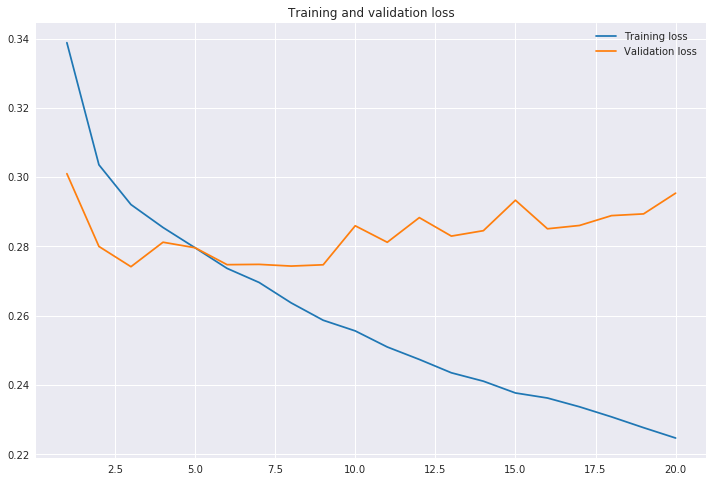

In [95]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Judging from the validation loss, this setup isn't
as good as the regularized GRU alone, but it's
significantly faster.  It looks at twice as much
data, which doesn't appear to help in this case, but
can be very helpful for other datasets.

### 6.4.5 Wrapping up

- In same way 2D convnets perform well for visual
  patterns in 2D space, 1D convnets perform well for
  processing temporal (1D) patterns.
  - And they are often faster alternatives to RNNs.
- 1D convnets are structured typically like their 
  2D image processing equivalents, layers of 
  `Conv1D` followed by 1D pooling layers, ending
  with a global pooling or flattening operation.
- Because RNNs can be expensive, but 1D convnets are
  much cheapter computationally, it can be a good
  strategy to prepreocess with a few layers of 1D
  convnets before using a RNN.

### Chapter Summary

- This chapter was about processing sequence and
  time series data
  - Tokenize text
  - Word embeddings and embedding spaces
  - What are recurrent networks and how they work
  - How to stack RNN layers
  - What are bidirectional RNN and when and for
    what types of series data are they useful.
  - How to use 1D convents for sequence processing
  - How to combine 1D convnets and RNNs to process
    long sequences.
- You can use RNNs for timeseries regressions
  ("predicting the future"), timeseries classification,
  anomaly detection in timeseries, and sequence
  labeling.
- Similarly, you can use 1D convnets for machine
  translation (sequence-to-sequence convolutional models),
  document classification and spelling correction.
- If *global order matters* in your sequence data,
  then it's preferable to use a recurrent network
  to process it.  This is typically the case for
  timeseries, where the recent past is likely to be
  more informative than the distant past.
- If *global ordering isn't fundamentally meaningful*
  then 1D convnets will turn out to work at least
  as well and are computationally cheaper.  This is
  often the case for text data.